# EventSeg-demo

### Imports

In [30]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn import decomposition
from sklearn.model_selection import LeaveOneOut, KFold

from brainiak.eventseg.event import EventSegment

### Make a data directory

In [3]:
!mkdir data

### Download data

> This will take > 15 seconds

In [6]:
download_data("data")

Successful download in 	 data


### Load data

In [7]:
D = load_data(path="data", dataset="sherlock")

Access variables like 
 D["BOLD"] 
 D["coords"] 
 D["human_bounds"]


### Look at some BOLD data

Text(0, 0.5, 'Regions')

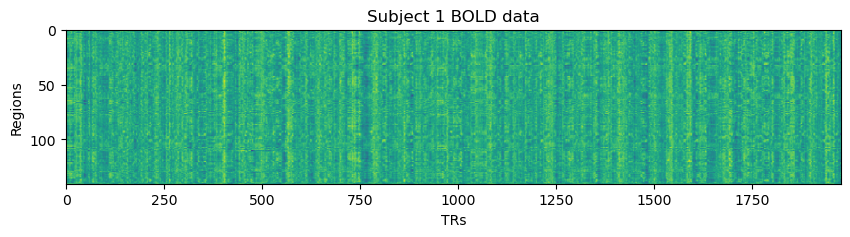

In [13]:
plt.figure(figsize=(10, 2))
plt.imshow(D["BOLD"][:, :, 1], aspect='auto')
plt.title('Subject 1 BOLD data')
plt.xlabel("TRs")
plt.ylabel("Regions")

### Formal model fitting

This is the nested cross validation skeleton

In [25]:
# get some variables
nReg, nTRs, nSubs = np.shape(D['BOLD'])

# nested CV constants
n_splits_inner = 4
subj_id_all = np.array([i for i in range(nSubs)])

# set up outer loop loo structure
loo_outer = LeaveOneOut()
loo_outer.get_n_splits(subj_id_all)
for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_all):
    print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)
    
    # set up inner loop loo structure
    subj_id_all_inner = subj_id_all[subj_id_train_outer]
    kf = KFold(n_splits=n_splits_inner)
    kf.get_n_splits(subj_id_train_outer)
    
    print('Inner:')
    for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):
        # inplace update the ids w.r.t. to the inner training set
        subj_id_train_inner = subj_id_all_inner[subj_id_train_inner]
        subj_id_test_inner = subj_id_all_inner[subj_id_test_inner]
        print("-Train:", subj_id_train_inner, "Test:", subj_id_test_inner, ', now try different k...')
    print()

Outer:	Train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [0]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16] Test: [1 2 3 4] , now try different k...
-Train: [ 1  2  3  4  9 10 11 12 13 14 15 16] Test: [5 6 7 8] , now try different k...
-Train: [ 1  2  3  4  5  6  7  8 13 14 15 16] Test: [ 9 10 11 12] , now try different k...
-Train: [ 1  2  3  4  5  6  7  8  9 10 11 12] Test: [13 14 15 16] , now try different k...

Outer:	Train: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [1]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16] Test: [0 2 3 4] , now try different k...
-Train: [ 0  2  3  4  9 10 11 12 13 14 15 16] Test: [5 6 7 8] , now try different k...
-Train: [ 0  2  3  4  5  6  7  8 13 14 15 16] Test: [ 9 10 11 12] , now try different k...
-Train: [ 0  2  3  4  5  6  7  8  9 10 11 12] Test: [13 14 15 16] , now try different k...

Outer:	Train: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [2]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 1

### Inner loop: Tune `k`

> This is computationally intensive and is scaled by `k` and the training data.

> It is recommended to connect to a remote server or HPC.

In [41]:
# parse subjects
subj_id_test = 0
subj_id_val = 1 
subj_id_train = [
    subj_id for subj_id in range(nSubs) 
    if subj_id not in [subj_id_test, subj_id_val]
]

BOLD_train = D['BOLD'][:,:,subj_id_train]
BOLD_val = D['BOLD'][:,:,subj_id_val]
BOLD_test = D['BOLD'][:,:,subj_id_test]

# get some k's (adjust as needed)
k_vals = np.arange(1, 3, 1)

# track log-likelihoods
log_likely = []

# fit
for k in k_vals:
    # Fit HMM on training data
    HMM = EventSegment(n_events=k)
    HMM.fit(BOLD_train.tolist())

    # collect LL
    ll = HMM.ll_
    log_likely.append(ll)


print('Whole dataset:\t', np.shape(D['BOLD']))
print('Training set:\t', np.shape(BOLD_train))
print('Tune set:\t', np.shape(BOLD_val))
print('Test set:\t', np.shape(BOLD_test))

print(subj_id_train)
print(subj_id_val)
print(subj_id_test)